In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, mean_absolute_error
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
# import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

import utilities

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


sex_colors = ['#002c92', '#d80075']
class_colors = ['skyblue', 'lightgreen', 'salmon']

COLORS = {'BLUE': '#3D6FFF',
          'RED': '#FF3D3D',
          'ORANGE': '#FF8E35',
          'PURPLE': '#BB58FF',
          'GREEN': '#32CD32',
          'YELLOW': '#F9DB00',
          'PINK': '#FFC0CB',
          'BROWN': '#8B4513',
          'CYAN': '#00FFFF',
}


In [6]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [7]:
print('_____Train dataset_____')
df_train.head()

_____Train dataset_____


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [8]:
print('_____Test dataset_____')
df_test.head()

_____Test dataset_____


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


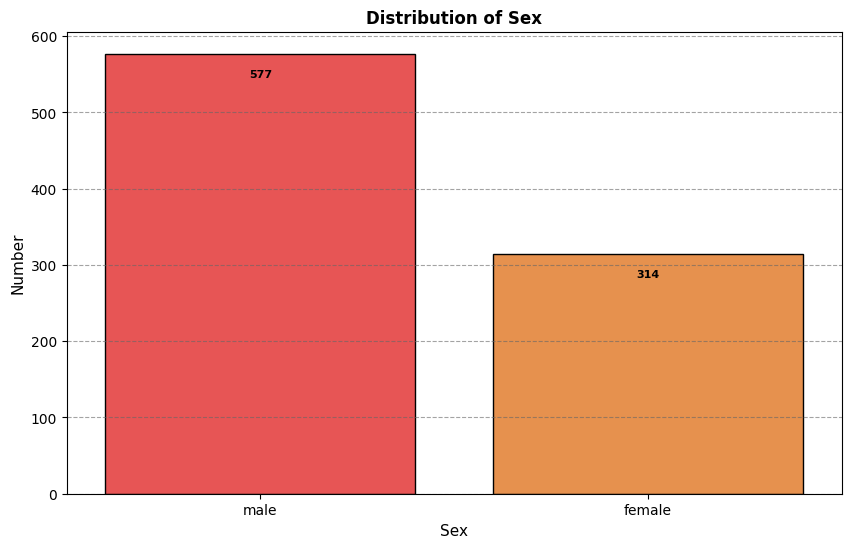

In [9]:
utilities.plot_hist_discrete_feature(df_train, 'Sex', color=[COLORS['RED'], COLORS['ORANGE']], frequency=False)

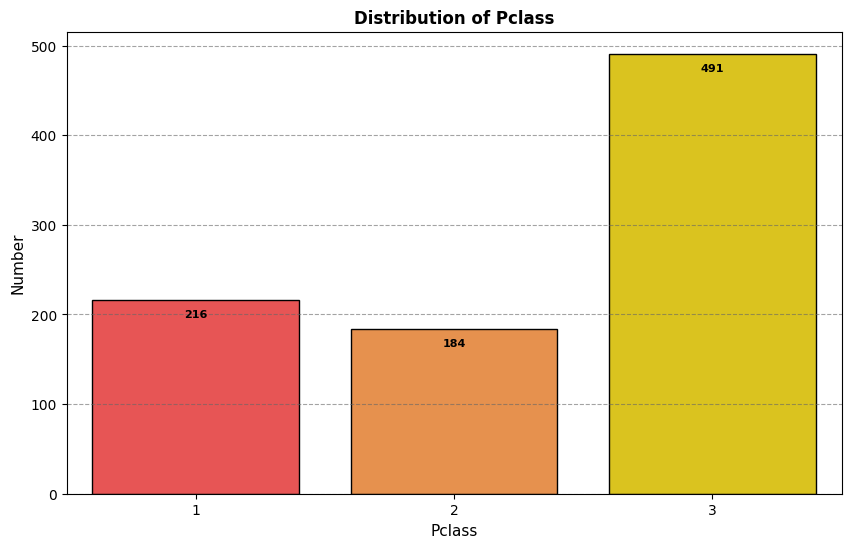

In [10]:
utilities.plot_hist_discrete_feature(df_train, 'Pclass', color=[COLORS['RED'], COLORS['ORANGE'], COLORS['YELLOW']], frequency=False)

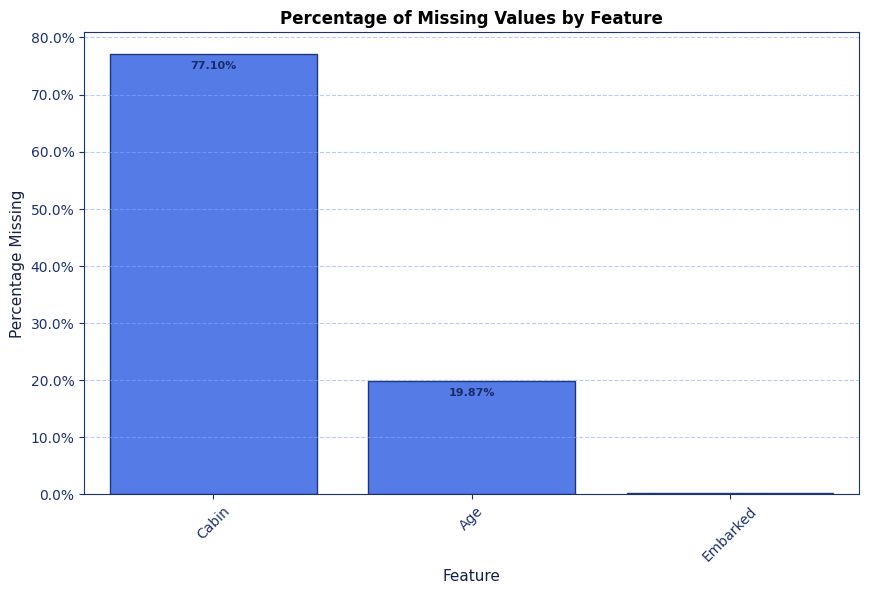

,Total Missing,Percentage Missing
Cabin,687,77.104377
Age,177,19.865320
Embarked,2,0.224467
PassengerId,0,0.000000
Survived,0,0.000000
Pclass,0,0.000000
Name,0,0.000000
Sex,0,0.000000
SibSp,0,0.000000
Parch,0,0.000000


In [11]:
utilities.plot_missing_data(df_train, percentage=10)

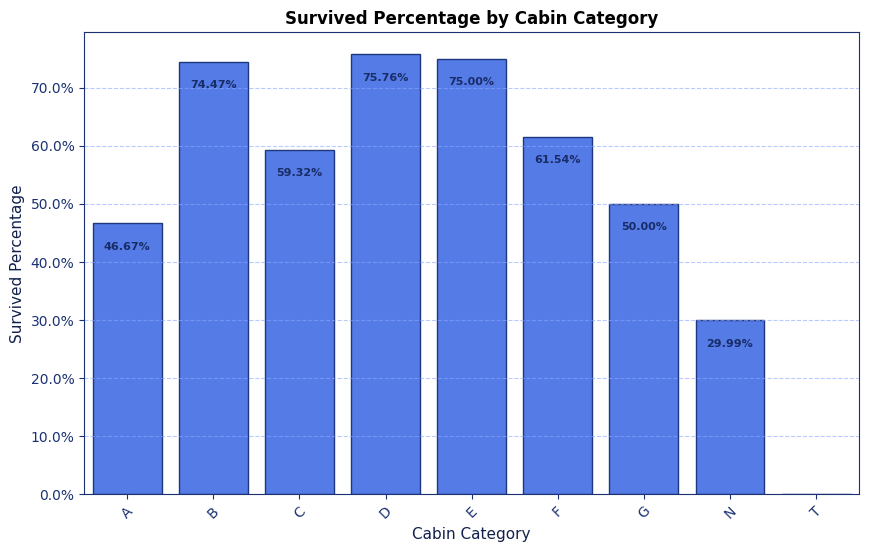

,Group Percentage,Total,Grouped total
Cabin,,,
A,46.666667,15,7
B,74.468085,47,35
C,59.322034,59,35
D,75.757576,33,25
E,75.000000,32,24
F,61.538462,13,8
G,50.000000,4,2
N,29.985444,687,206
T,0.000000,1,0


In [12]:
df_train['Cabin'].fillna('N0', inplace=True)
df_train['Cabin'] = df_train['Cabin'].str.extract(r'([A-Za-z]+)')

df_test['Cabin'].fillna('N0', inplace=True)
df_test['Cabin'] = df_train['Cabin'].str.extract(r'([A-Za-z]+)')

df_cabin_survival = utilities.plot_groupby(df_train, 'Cabin', 'Survived')
df_cabin_survival

In [13]:
df_train["Family_Size"] = df_train["SibSp"] + df_train["Parch"]
df_train.drop(["SibSp", "Parch"], inplace=True, axis=1)
df_test["Family_Size"] = df_test["SibSp"] + df_test["Parch"]
df_test.drop(labels= ["SibSp", "Parch"], inplace=True, axis=1)

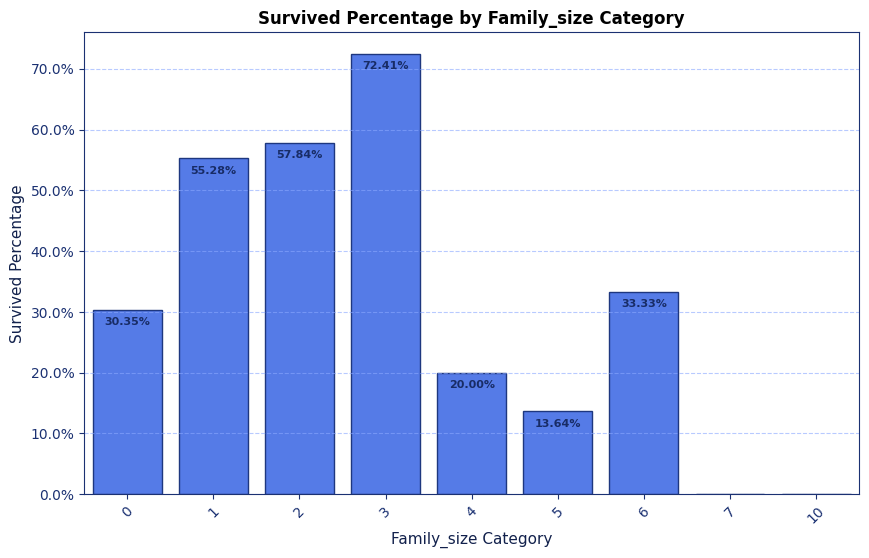

,Group Percentage,Total,Grouped total
Family_Size,,,
0,30.353818,537,163
1,55.279503,161,89
2,57.843137,102,59
3,72.413793,29,21
4,20.000000,15,3
5,13.636364,22,3
6,33.333333,12,4
7,0.000000,6,0
10,0.000000,7,0


In [14]:
df_family_survival = utilities.plot_groupby(df_train, 'Family_Size', 'Survived')
df_family_survival

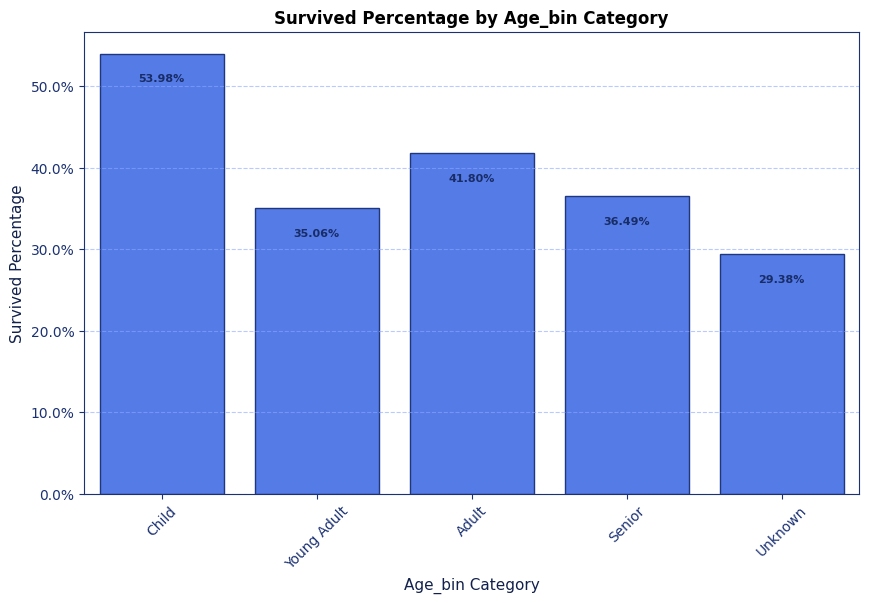

,Group Percentage,Total,Grouped total
Age_Bin,,,
Child,53.982301,113,61
Young Adult,35.055351,271,95
Adult,41.796875,256,107
Senior,36.486486,74,27
Unknown,29.378531,177,52


In [15]:
age_bins = [0, 18, 30, 50, 120]
age_labels = ['Child', 'Young Adult', 'Adult', 'Senior']

df_train['Age_Bin'] = pd.cut(df_train['Age'], bins=age_bins, labels=age_labels, right=False)
df_train['Age_Bin']=(df_train['Age_Bin'].cat.add_categories('Unknown').fillna('Unknown'))
df_train.drop('Age', axis=1, inplace=True)

df_test['Age_Bin'] = pd.cut(df_test['Age'], bins=age_bins, labels=age_labels, right=False)
df_test['Age_Bin']=(df_test['Age_Bin'].cat.add_categories('Unknown').fillna('Unknown'))
df_test.drop('Age', axis=1, inplace=True)

df_age_survival = utilities.plot_groupby(df_train, 'Age_Bin', 'Survived')
df_age_survival

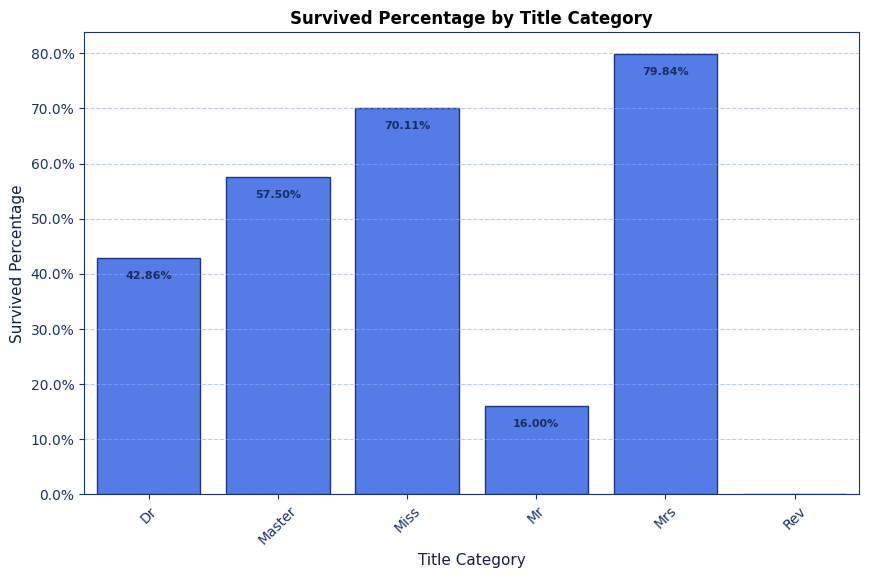

,Group Percentage,Total,Grouped total
Title,,,
Dr,42.857143,7,3
Master,57.500000,40,23
Miss,70.108696,184,129
Mr,16.000000,525,84
Mrs,79.844961,129,103
Rev,0.000000,6,0


In [16]:
title_mapping = {
    'Sir': 'Mr',
    'Jonkheer': 'Mr',
    'Countess': 'Mrs',
    'Lady': 'Mrs',
    'Mlle': 'Miss',
    'Ms': 'Mrs',
    'Capt': 'Mr',
    'Mme': 'Mrs',
    'Don': 'Mr',
    'Major': 'Mr',
    'Col': 'Mr',
    'Dona': 'Mrs'
}

df_train['Title'] = df_train['Name'].str.extract(' ([A-Za-z]+)\.')
df_train['Title'].replace(title_mapping, inplace=True)
df_train.drop('Name', axis=1, inplace=True)
df_test['Title'] = df_test['Name'].str.extract(' ([A-Za-z]+)\.')
df_test['Title'].replace(title_mapping, inplace=True)
df_test.drop('Name', axis=1, inplace=True)

df_title_survival = utilities.plot_groupby(df_train, 'Title', 'Survived')
df_title_survival

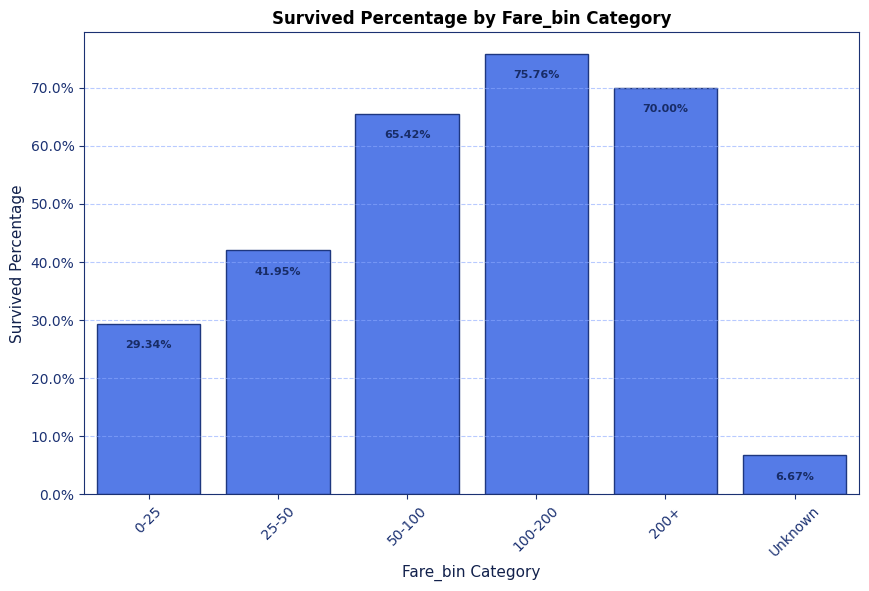

,Group Percentage,Total,Grouped total
Fare_bin,,,
0-25,29.335793,542,159
25-50,41.954023,174,73
50-100,65.420561,107,70
100-200,75.757576,33,25
200+,70.000000,20,14
Unknown,6.666667,15,1


In [17]:
fare_bins = [0, 25, 50, 100, 200, np.inf]
labels_fare = ['0-25', '25-50', '50-100', '100-200', '200+']

df_train['Fare_bin'] = pd.cut(df_train['Fare'], bins=fare_bins, labels=labels_fare)
df_train['Fare_bin']=(df_train['Fare_bin'].cat.add_categories('Unknown').fillna('Unknown'))
df_train.drop('Fare', axis=1, inplace=True)

df_test['Fare_bin'] = pd.cut(df_test['Fare'], bins=fare_bins, labels=labels_fare)
df_test['Fare_bin']=(df_test['Fare_bin'].cat.add_categories('Unknown').fillna('Unknown'))
df_test.drop('Fare', axis=1, inplace=True)


df_fare_survival = utilities.plot_groupby(df_train, 'Fare_bin', 'Survived')
df_fare_survival


In [18]:
df_train['isAlone'] = (df_train['Family_Size'] == 0).astype(int)
df_test['isAlone'] = (df_test['Family_Size'] == 0).astype(int)

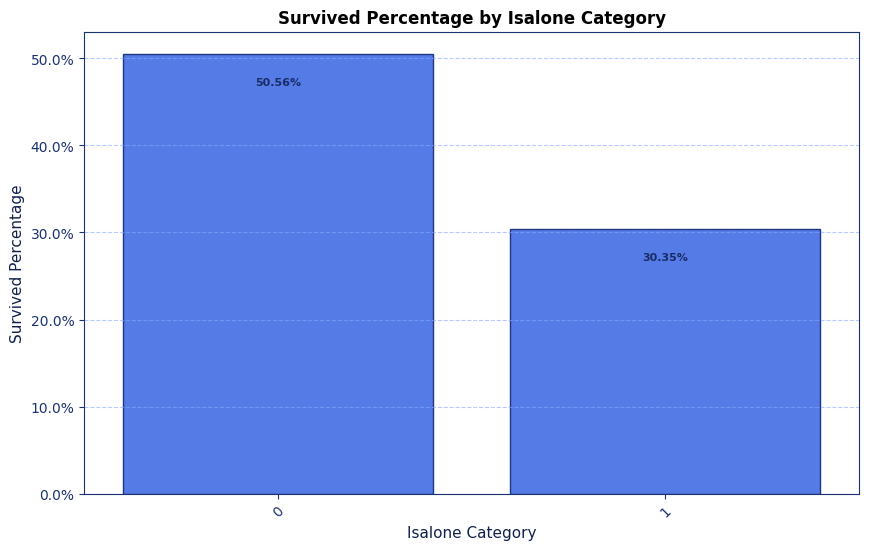

,Group Percentage,Total,Grouped total
isAlone,,,
0,50.564972,354,179
1,30.353818,537,163


In [19]:
df_fare_survival = utilities.plot_groupby(df_train, 'isAlone', 'Survived')
df_fare_survival

In [20]:
dropped_column = ['PassengerId', 'Ticket']
df_train.drop(dropped_column, axis=1, inplace=True)
df_test_new = df_test.drop(dropped_column, axis=1, inplace=False)


df_train['Embarked'].fillna(df_train['Embarked'].mode()[0], inplace=True)

In [21]:
missing_values_train = df_train.isnull()
missing_values_test = df_test.isnull()

print(missing_values_train.sum(), missing_values_test.sum())

Survived       0
Pclass         0
Sex            0
Cabin          0
Embarked       0
Family_Size    0
Age_Bin        0
Title          0
Fare_bin       0
isAlone        0
dtype: int64 PassengerId    0
Pclass         0
Sex            0
Ticket         0
Cabin          0
Embarked       0
Family_Size    0
Age_Bin        0
Title          0
Fare_bin       0
isAlone        0
dtype: int64


In [22]:

df_train['Sex'] = (df_train['Sex'] == 'male')

label_encoder = LabelEncoder()
df_train['Pclass'] = label_encoder.fit_transform(df_train['Pclass'])
df_train['Age_Bin'] = label_encoder.fit_transform(df_train['Age_Bin'])
df_train['Fare_bin'] = label_encoder.fit_transform(df_train['Fare_bin'])

df_train = pd.get_dummies(df_train, columns=['Cabin', 'Embarked', 'Title'], prefix=['Cabin', 'Embarked', 'Title'])

# df_train.drop(['Pclass', 'Age_Bin', 'Fare_bin', 'Cabin_T'], axis=1, inplace=True)




df_test_new['Sex'] = (df_test_new['Sex'] == 'male')

label_encoder = LabelEncoder()
df_test_new['Pclass'] = label_encoder.fit_transform(df_test_new['Pclass'])
df_test_new['Age_Bin'] = label_encoder.fit_transform(df_test_new['Age_Bin'])
df_test_new['Fare_bin'] = label_encoder.fit_transform(df_test_new['Fare_bin'])

df_test_new = pd.get_dummies(df_test_new, columns=['Cabin', 'Embarked', 'Title'], prefix=['Cabin', 'Embarked', 'Title'])

# df_test_new.drop(['Pclass', 'Age_Bin', 'Fare_bin', 'Cabin_T'], axis=1, inplace=True)


In [23]:
df_train.head()

,Survived,Pclass,Sex,Family_Size,Age_Bin,Fare_bin,isAlone,Cabin_A,Cabin_B,Cabin_C,...,Cabin_T,Embarked_C,Embarked_Q,Embarked_S,Title_Dr,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rev
0,0,2,True,1,4,0,0,False,False,False,...,False,False,False,True,False,False,False,True,False,False
1,1,0,False,1,0,4,0,False,False,True,...,False,True,False,False,False,False,False,False,True,False
2,1,2,False,0,4,0,1,False,False,False,...,False,False,False,True,False,False,True,False,False,False
3,1,0,False,1,0,4,0,False,False,True,...,False,False,False,True,False,False,False,False,True,False
4,0,2,True,0,0,0,1,False,False,False,...,False,False,False,True,False,False,False,True,False,False


In [24]:
import xgboost as xgb

X = df_train.drop('Survived', axis=1)
y = df_train['Survived']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the feature data (not needed for Decision Tree)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Models to evaluate
models = {
    'Logistic Regression': {
        'model': LogisticRegression(),
        'params': {
            'C': [0.01, 0.1, 1, 10],
        },
    },
    'SVM': {
        'model': SVC(),
        'params': {
            'C': np.linspace(0.1, 10, 100),
            'kernel': ['linear', 'rbf'],
        },
    },
    'Decision Tree': {
        'model': DecisionTreeClassifier(),
        'params': {
            'criterion': ['gini', 'entropy'],
            'max_depth': [None, 5, 10, 20],
        },
    },
    
}

models['Random Forest'] = {
    'model': RandomForestClassifier(),
    'params': {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 5, 10, 20],
    },
}

models['XGBoost'] = {
    'model': xgb.XGBClassifier(),
    'params': {
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 5, 7],
    },
}

models['K-Nearest Neighbors'] = {
    'model': KNeighborsClassifier(),
    'params': {
        'n_neighbors': [3, 5, 7, 9],
        'weights': ['uniform', 'distance'],
    },
}

# Perform GridSearch for each model
results = {}
for model_name, model_info in models.items():
    model = model_info['model']
    param_grid = model_info['params']

    grid_search = GridSearchCV(model, param_grid, cv=5, n_jobs=-1)
    grid_search.fit(X_train_scaled if 'Logistic' in model_name else X_train, y_train)

    best_params = grid_search.best_params_
    best_model = grid_search.best_estimator_

    y_pred = best_model.predict(X_test_scaled if 'Logistic' in model_name else X_test)
    accuracy = accuracy_score(y_test, y_pred)

    results[model_name] = {
        'best_params': best_params,
        'best_model': best_model,
        'accuracy': accuracy,
    }

# Display the results
for model_name, result in results.items():
    print(f"Model: {model_name}")
    print(f"Best Parameters: {result['best_params']}")
    print(f"Accuracy: {result['accuracy']}\n")

Model: Logistic Regression
Best Parameters: {'C': 0.1}
Accuracy: 0.7932960893854749

Model: SVM
Best Parameters: {'C': 1.5000000000000002, 'kernel': 'rbf'}
Accuracy: 0.8268156424581006

Model: Decision Tree
Best Parameters: {'criterion': 'gini', 'max_depth': 5}
Accuracy: 0.8324022346368715

Model: Random Forest
Best Parameters: {'max_depth': 5, 'n_estimators': 100}
Accuracy: 0.8268156424581006

Model: XGBoost
Best Parameters: {'max_depth': 3, 'n_estimators': 200}
Accuracy: 0.8324022346368715

Model: K-Nearest Neighbors
Best Parameters: {'n_neighbors': 3, 'weights': 'distance'}
Accuracy: 0.7932960893854749



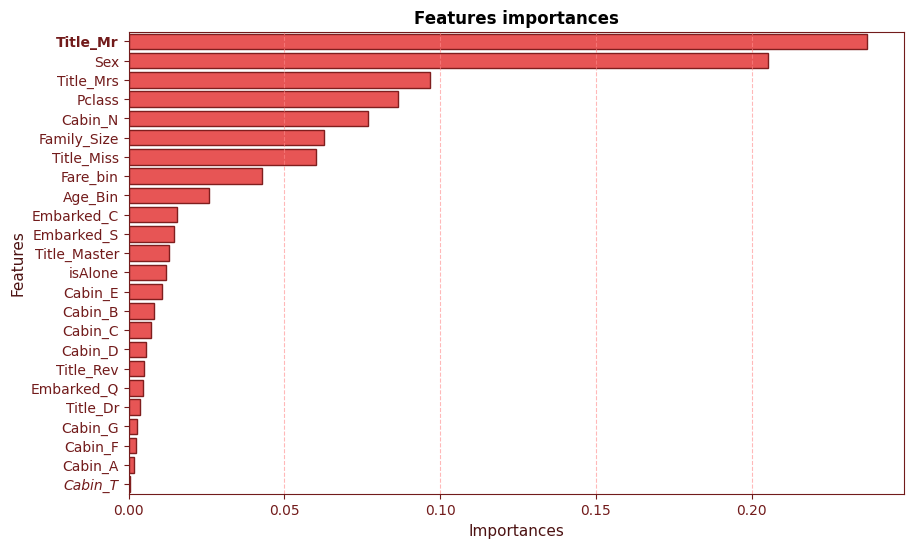

,21,1,22,0,13,2,20,4,3,15,...,7,8,9,23,16,18,12,11,6,14
Features,Title_Mr,Sex,Title_Mrs,Pclass,Cabin_N,Family_Size,Title_Miss,Fare_bin,Age_Bin,Embarked_C,...,Cabin_B,Cabin_C,Cabin_D,Title_Rev,Embarked_Q,Title_Dr,Cabin_G,Cabin_F,Cabin_A,Cabin_T
Importances,0.236909,0.205096,0.096592,0.086517,0.076747,0.062649,0.060232,0.042813,0.025664,0.015385,...,0.008019,0.007261,0.005528,0.005058,0.004528,0.003601,0.002752,0.002302,0.001841,0.000399


In [33]:
best_model = results['Random Forest']['best_model']

# Get feature importances
feature_importances = best_model.feature_importances_

utilities.plot_feature_importance(X.columns, feature_importances, color=COLORS['RED'])

In [34]:
df_test_new

,Pclass,Sex,Family_Size,Age_Bin,Fare_bin,isAlone,Cabin_A,Cabin_B,Cabin_C,Cabin_D,...,Cabin_T,Embarked_C,Embarked_Q,Embarked_S,Title_Dr,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rev
0,2,True,0,0,0,1,False,False,False,False,...,False,False,True,False,False,False,False,True,False,False
1,2,False,1,0,0,0,False,False,True,False,...,False,False,False,True,False,False,False,False,True,False
2,1,True,0,2,0,1,False,False,False,False,...,False,False,True,False,False,False,False,True,False,False
3,2,True,0,4,0,1,False,False,True,False,...,False,False,False,True,False,False,False,True,False,False
4,2,False,2,4,0,0,False,False,False,False,...,False,False,False,True,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,2,True,0,3,0,1,False,False,False,False,...,False,False,False,True,False,False,False,True,False,False
414,0,False,0,0,1,1,False,False,False,False,...,False,True,False,False,False,False,False,False,True,False
415,2,True,0,0,0,1,False,False,False,False,...,False,False,False,True,False,False,False,True,False,False
416,2,True,0,3,0,1,False,False,False,False,...,False,False,False,True,False,False,False,True,False,False


In [71]:
scaler = StandardScaler()

# model = SVC(C= 5.8, kernel= 'rbf')
model = xgb.XGBClassifier(max_depth= 3, n_estimators= 200)
model.fit(scaler.fit_transform(X), y)

y_pred = model.predict(scaler.fit_transform(df_test_new))

# Create a DataFrame with 'PassengerId' and 'Survived' predictions
result_df = pd.DataFrame({'PassengerId': df_test['PassengerId'], 'Survived': y_pred})

# Save the predictions to a CSV file
result_df.to_csv('predictions.csv', index=False)